# Train a review classifier with BERT and Amazon SageMaker

### Introduction

In the previous lab you performed Feature Engineering on the raw dataset, preparing it for training the model. Now you will train a text classifier using a variant of BERT called [RoBERTa](https://arxiv.org/abs/1907.11692) - a Robustly Optimized BERT Pretraining Approach - within a PyTorch model ran as a SageMaker Training Job.

### Table of Contents

- [1. Configure dataset, hyper-parameters and evaluation metrics](#c2w2-1.)
  - [1.1. Configure dataset](#c2w2-1.1.)
    - [Exercise 1](#c2w2-ex-1)
    - [Exercise 2](#c2w2-ex-2)
    - [Exercise 3](#c2w2-ex-3)
  - [1.2. Configure model hyper-parameters](#c2w2-1.2.)
  - [1.3. Setup evaluation metrics](#c2w2-1.3.)
  - [1.4. Setup Debugger and Profiler](#c2w2-1.4.)
- [2. Train model](#c2w2-2.)
  - [2.1. Setup the RoBERTa and PyTorch script to run on SageMaker](#c2w2-2.1.)
    - [Exercise 4](#c2w2-ex-4)
    - [Exercise 5](#c2w2-ex-5)
    - [Exercise 6](#c2w2-ex-6)
  - [2.2. Analyze Debugger results](#c2w2-2.2.)
  - [2.3. Download SageMaker debugger profiling report](#c2w2-2.3.)
- [3. Deploy the model](#c2w2-3.)
- [4. Test model](#c2w2-4.)

Let's review Amazon SageMaker "Bring Your Own Script" scheme:

![](images/sagemaker_scriptmode.png)

In this lab you will cover each part of the scheme. First, install and import the required modules:

In [1]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c2/w2')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

<a name='c2w2-1.'></a>
# 1. Configure dataset, hyper-parameters and evaluation metrics

<a name='c2w2-1.1.'></a>
### 1.1. Configure dataset

You have already transformed and balanced the data into a format that the model expects. Let's copy this data to S3. You will be using training and validation datasets to train the model. Test dataset will be used for tuning later. Setup the paths:

In [4]:
processed_train_data_s3_uri = 's3://{}/data/sentiment-train/'.format(bucket)
processed_validation_data_s3_uri = 's3://{}/data/sentiment-validation/'.format(bucket)

Upload the data to S3 bucket:

In [5]:
!aws s3 cp --recursive ./data/sentiment-train $processed_train_data_s3_uri
!aws s3 cp --recursive ./data/sentiment-validation $processed_validation_data_s3_uri

upload: data/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv to s3://sagemaker-us-east-1-188752983558/data/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv
upload: data/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv to s3://sagemaker-us-east-1-188752983558/data/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv


Check the existence of those files in the S3 bucket:

In [6]:
!aws s3 ls --recursive $processed_train_data_s3_uri

2022-06-24 14:22:05    4894416 data/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [7]:
!aws s3 ls --recursive $processed_validation_data_s3_uri

2022-06-24 14:22:05     276522 data/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv


You will need to setup the input data channels, wrapping the S3 locations in a `TrainingInput` object to use with the SageMaker Training Job. This can be organized as a dictionary

```python
data_channels = {
    'train': ..., # training data
    'validation': ... # validation data
}
```

where training and validation data are the Amazon SageMaker channels for S3 input data sources.

<a name='c2w2-ex-1'></a>
### Exercise 1

Create a train data channel.

**Instructions**: Pass the S3 input path for training data into the `sagemaker.inputs.TrainingInput` function.

In [8]:
s3_input_train_data = sagemaker.inputs.TrainingInput(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    s3_data=processed_train_data_s3_uri # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

<a name='c2w2-ex-2'></a>
### Exercise 2

Create a validation data channel.

**Instructions**: Pass the S3 input path for validation data into the `sagemaker.inputs.TrainingInput` function.

In [9]:
s3_input_validation_data = sagemaker.inputs.TrainingInput(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    s3_data=processed_validation_data_s3_uri # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

<a name='c2w2-ex-3'></a>
### Exercise 3

Organize data channels defined above as a dictionary.

In [10]:
data_channels = {
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    'train': s3_input_train_data, # Replace None
    'validation': s3_input_validation_data # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
}

<a name='c2w2-1.2.'></a>
### 1.2. Configure model hyper-parameters

Set the Training Job parameters including the instance type, instance count, learning rate, batch size etc. For the purposes of this lab, you will use a relatively small instance type. Please refer to [this link](https://aws.amazon.com/sagemaker/pricing/) for additional instance types that may work for your use cases outside of this lab.

In [11]:
max_seq_length=128 # maximum number of input tokens passed to BERT model
freeze_bert_layer=False # specifies the depth of training within the network
epochs=3
learning_rate=2e-5
train_batch_size=256
train_steps_per_epoch=50
validation_batch_size=256
validation_steps_per_epoch=50
seed=42
run_validation=True

train_instance_count=1
train_instance_type='ml.c5.9xlarge'
train_volume_size=256
input_mode='File'

Some of them will be passed into the PyTorch estimator in the hyperparameters argument. Let's setup the dictionary for that:

In [12]:
hyperparameters={
    'max_seq_length': max_seq_length,
    'freeze_bert_layer': freeze_bert_layer,
    'epochs': epochs,
    'learning_rate': learning_rate,
    'train_batch_size': train_batch_size,
    'train_steps_per_epoch': train_steps_per_epoch,
    'validation_batch_size': validation_batch_size,
    'validation_steps_per_epoch': validation_steps_per_epoch,    
    'seed': seed,
    'run_validation': run_validation
}

<a name='c2w2-1.3.'></a>
### 1.3. Setup evaluation metrics

Choose loss and accuracy as the evaluation metrics. The regular expressions `Regex` will capture the values of metrics that the algorithm will emit.

In [13]:
metric_definitions = [
     {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'val_acc: ([0-9.]+)'},
]

For example, these sample log lines...
```
[step: 100] val_loss: 0.76 - val_acc: 70.92%
```

...will produce the following metrics in CloudWatch:

`validation:loss` =  0.76

`validation:accuracy` = 70.92

<img src="images/cloudwatch_validation_metrics.png" align="left">

<a name='c2w2-1.4.'></a>
### 1.4. Setup Debugger and Profiler

Amazon SageMaker Debugger can be used to profile machine learning models, helping to identify and fix training issues caused by hardware resource usage. Setting some parameters in the SageMaker estimator, without any change to the training code, you can enable the collection of infrastructure and model metrics such as: CPU and GPU, RAM and GPU RAM, data loading time, time spent in ML operators running on CPU and GPU, distributed training metrics and many more. In addition, you can visualize how much time is spent in different phases, such as preprocessing, training loop, and postprocessing. If needed, you can drill down on each training epoch, and even on each function in your training script.
    
Define Debugger Rules as described here:  https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html

In [14]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

`DebuggerHookConfig` provides options to customize how debugging information is emitted and saved. `s3_output_path` argument value defines the location in Amazon S3 to store the output.

In [15]:
debugger_hook_config = DebuggerHookConfig(
    s3_output_path='s3://{}'.format(bucket),
)

`ProfilerConfig` sets the configuration for collecting system and framework metrics of SageMaker Training Jobs. Parameter `system_monitor_interval_millis` sets the time interval to collect system metrics (in milliseconds). Parameter `framework_profile_params` is the object for framework metrics profiling. Here you will set its local path, the step at which to start profiling, `start_step`, and the number of steps to profile, `num_steps`.

In [16]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10)
)

For monitoring and profiling the built-in rules you can use the `ProfilerReport`. It creates a profiling report and updates when the individual rules are triggered. If you trigger this `ProfilerReport` rule without any customized parameter as in the cell below, then the `ProfilerReport` rule triggers all of the built-in rules for monitoring and profiling with their default parameter values.

The profiling report can be downloaded while the Training Job is running or after the job has finished.

In [17]:
rules=[ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

<a name='c2w2-2.'></a>
# 2. Train model

<a name='c2w2-2.1.'></a>
### 2.1. Setup the RoBERTa and PyTorch script to run on SageMaker
You will prepare the PyTorch model to run as a SageMaker Training Job in a separate Python file, which will be called during the training. 

Here you will be using the pre-trained model `roberta-base`. The information about the available models can be found in the [Hugging Face website](https://huggingface.co/models).

<a name='c2w2-ex-4'></a>
### Exercise 4

1. Open the file [src/train.py](src/train.py). Go through the comments to understand its content.
2. Find and review the `configure_model()` function, which contains the RoBERTa model configuration. 
3. In the following function investigate given mapping `label2id` of a 0-indexed list of classes used by BERT \[0, 1, 2\] to the list of the sentiment values \[-1, 0, 1\]:

```python
    config = RobertaConfig.from_pretrained(
        PRE_TRAINED_MODEL_NAME, 
        num_labels=len(classes),
        id2label={
            ...: ...,
            ...: ...,
            ...: ...,
        },
        label2id={
            -1: 0,
            0: 1,
            1: 2,
        }
    )

``` 

4. Update the function setting up the opposite mapping `id2label`: sentiment values \[-1, 0, 1\] to a 0-indexed list of classes used by BERT.

5. Save the file [src/train.py](src/train.py) (with the menu command File -> Save Python File).

In [18]:
import sys, importlib
sys.path.append('src/')

import train

# reload the module if it has been previously loaded
if 'train' in sys.modules:
    importlib.reload(train)

# Ignore warnings below
config = train.configure_model()

label_0 = config.id2label[0]
label_1 = config.id2label[1]
label_2 = config.id2label[2]

updated_correctly = False

if label_0 != -1 or label_1 != 0 or label_2 != 1:
    print('#######################################################################################')
    print('Please check that the function \'configure_model\' in the file src/train.py is complete.')
    print('########################################################################################')
    raise Exception('Please check that the function \'configure_model\' in the file src/train.py is complete.')
else:
    print('##################')    
    print('Updated correctly!')        
    print('##################')        

    updated_correctly = True

##################
Updated correctly!
##################


Setup the PyTorch estimator to train our model. For more information on the PyTorch estimator, see the documentation [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html). 

In [19]:
from sagemaker.pytorch import PyTorch as PyTorchEstimator

if updated_correctly:
    estimator = PyTorchEstimator(
        entry_point='train.py',
        source_dir='src',
        role=role,
        instance_count=train_instance_count,
        instance_type=train_instance_type,
        volume_size=train_volume_size,
        py_version='py3', # dynamically retrieves the correct training image (Python 3)
        framework_version='1.6.0', # dynamically retrieves the correct training image (PyTorch)
        hyperparameters=hyperparameters,
        metric_definitions=metric_definitions,
        input_mode=input_mode,
        debugger_hook_config=debugger_hook_config,
        profiler_config=profiler_config,
        rules=rules
    )

<a name='c2w2-ex-5'></a>
### Exercise 5

Launch the SageMaker Training Job which will be fitting the model to the dataset.

**Instructions**: Use the `estimator.fit` function, passing the configured train and validation inputs (data channels).

```python
estimator.fit(
    inputs=..., # train and validation input
    wait=False # do not wait for the job to complete before continuing
)
``` 

In [20]:
estimator.fit(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    inputs=data_channels, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    wait=False
)

You can refer to the last Training Job using the estimator function `latest_training_job`. Then the Training Job name can be found with the `name` function:

In [21]:
training_job_name = estimator.latest_training_job.name

print('Training Job name: {}'.format(training_job_name))

Training Job name: pytorch-training-2022-06-24-14-22-08-269


You can also load the information about the Training Job using the function `describe()`. The result is in dictionary format. Let's check that it has the same Training Job name:

In [22]:
training_job_name = estimator.latest_training_job.describe()['TrainingJobName']

print('Training Job name: {}'.format(training_job_name))

Training Job name: pytorch-training-2022-06-24-14-22-08-269


<a name='c2w2-ex-6'></a>
### Exercise 6

Pull the Training Job status from the Training Job description.

**Instructions**: Print the keys of the Training Job description dictionary, choose the one related to the primary status of the Training Job and print the value of it.

In [23]:
print(estimator.latest_training_job.describe().keys())

dict_keys(['TrainingJobName', 'TrainingJobArn', 'TrainingJobStatus', 'SecondaryStatus', 'HyperParameters', 'AlgorithmSpecification', 'RoleArn', 'InputDataConfig', 'OutputDataConfig', 'ResourceConfig', 'StoppingCondition', 'CreationTime', 'LastModifiedTime', 'SecondaryStatusTransitions', 'EnableNetworkIsolation', 'EnableInterContainerTrafficEncryption', 'EnableManagedSpotTraining', 'DebugHookConfig', 'ProfilerConfig', 'ProfilerRuleConfigurations', 'ProfilerRuleEvaluationStatuses', 'ProfilingStatus', 'ResponseMetadata'])


In [26]:
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
training_job_status_primary = estimator.latest_training_job.describe()['TrainingJobStatus'] # Replace None
### END SOLUTION - DO NOT delete this comment for grading purposes
print('Training Job status: {}'.format(training_job_status_primary))

Training Job status: InProgress


Review the Training Job in the console.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon SageMaker` -> `Training jobs`
- check the name of the Training Job, its status and other available information
- review metrics in the `Monitor` section

In [27]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a></b>'.format(region, training_job_name)))

Review the Cloud Watch logs (after about 5 minutes).

**Instructions**: 
- open the link
- open the log stream with the name, which starts from the training job name
- have a quick look at the log messages

In [28]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, training_job_name)))

In [29]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 output data</a> after the Training Job has completed</b>'.format(bucket, training_job_name, region)))


Wait for the Training Job to complete.

### _This cell will take approximately 30-40 minutes to run._

In [ ]:
%%time

estimator.latest_training_job.wait(logs=False)


2022-06-24 14:23:31 Starting - Preparing the instances for training.
2022-06-24 14:23:44 Downloading - Downloading input data..
2022-06-24 14:23:59 Training - Downloading the training image........
2022-06-24 14:24:45 Training - Training image download completed. Training in progress.................................................................................................................................................................................................................................................................................................................................................................
2022-06-24 15:07:12 Uploading - Uploading generated training model.....................................
2022-06-24 15:10:27 Completed - Training job completed
CPU times: user 2.29 s, sys: 250 ms, total: 2.54 s
Wall time: 46min 52s


_Wait until the ^^ Training Job ^^ completes above_

Review the training metrics.

In [31]:
df_metrics = estimator.training_job_analytics.dataframe()
df_metrics

,timestamp,metric_name,value
0,0.0,validation:loss,1.10
1,1380.0,validation:loss,1.02
2,1920.0,validation:loss,0.66
3,0.0,validation:accuracy,34.77
4,1380.0,validation:accuracy,50.39
5,1920.0,validation:accuracy,69.14


You can query and plot the training metrics:

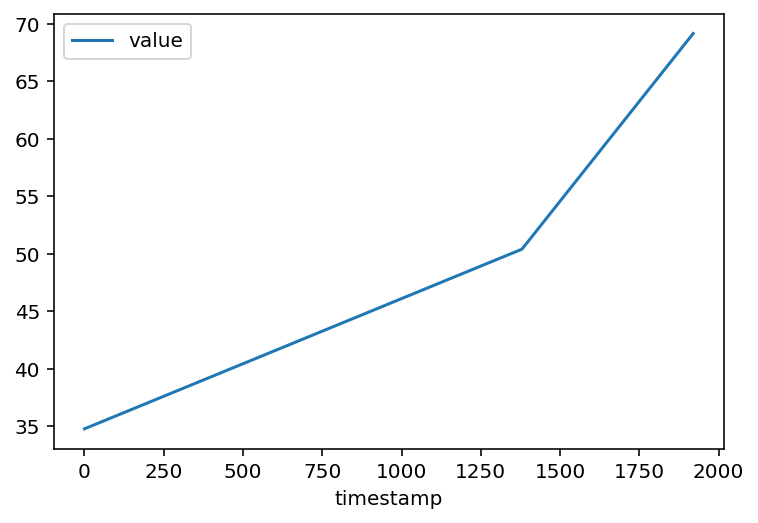

In [32]:
df_metrics.query("metric_name=='validation:accuracy'").plot(x='timestamp', y='value')

<a name='c2w2-2.2.'></a>
### 2.2. Analyze Debugger results

You can now explore the debugger output data:

In [33]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/">S3 debugger output data</a></b>'.format(
            bucket, training_job_name
        )
    )
)

<a name='c2w2-2.3.'></a>
### 2.3. Download SageMaker debugger profiling report

You can download and review the debugger profiling report. Here is the path in the S3 bucket:

In [34]:
profiler_report_s3_uri = "s3://{}/{}/rule-output/ProfilerReport/profiler-output".format(bucket, training_job_name)

You can list the report files:

In [35]:
!aws s3 ls $profiler_report_s3_uri/

                           PRE profiler-reports/
2022-06-24 15:10:31     364481 profiler-report.html
2022-06-24 15:10:30     211531 profiler-report.ipynb


The folder `profiler-reports` contains the built-in rule analysis components, stored in JSON and a Jupyter notebook. They are aggregated into the report.

In [36]:
!aws s3 cp --recursive $profiler_report_s3_uri ./profiler_report/

download: s3://sagemaker-us-east-1-188752983558/pytorch-training-2022-06-24-14-22-08-269/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to profiler_report/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-188752983558/pytorch-training-2022-06-24-14-22-08-269/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to profiler_report/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-188752983558/pytorch-training-2022-06-24-14-22-08-269/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to profiler_report/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-188752983558/pytorch-training-2022-06-24-14-22-08-269/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to profiler_report/profiler-report.ipynb
download: s3://sagemaker-us-east-1-188752983558/pytorch-training-2022-06-24-14-22-08-269/rule-output/ProfilerReport/profiler-output/profiler-repor

You can review the profiler report in the console.

**Note**: Click `Trust HTML` in the profiler-report.html tab that opens (on top of the document).

In [37]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./profiler_report/profiler-report.html">profiler report</a></b>'))

<a name='c2w2-3.'></a>
# 3. Deploy the model
Create a custom `SentimentPredictor` that encapsulates a JSONLines serializer and deserializer. To be passed into the `PyTorchModel` it needs to be wrapped as a class.

In [38]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

class SentimentPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, 
                         sagemaker_session=sagemaker_session, 
                         serializer=JSONLinesSerializer(),
                         deserializer=JSONLinesDeserializer())

In [39]:
import time
from sagemaker.pytorch.model import PyTorchModel

timestamp = int(time.time())

pytorch_model_name = '{}-{}-{}'.format(training_job_name, 'pt', timestamp)

model = PyTorchModel(name=pytorch_model_name,
                     model_data=estimator.model_data,
                     predictor_cls=SentimentPredictor,
                     entry_point='inference.py',
                     source_dir='src',
                     framework_version='1.6.0',
                     py_version='py3',
                     role=role)

In [40]:
import time

pytorch_endpoint_name = '{}-{}-{}'.format(training_job_name, 'pt', timestamp)

print(pytorch_endpoint_name)

pytorch-training-2022-06-24-14-22-08-269-pt-1656083540


### _This cell will take approximately 5-10 minutes to run._

In [ ]:
%%time

predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.m5.large', 
                         endpoint_name=pytorch_endpoint_name)

---------

Review the Endpoint in the AWS console.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon SageMaker` -> `Endpoints`
- check the name of the Endpoint, its status and other available information

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST Endpoint</a></b>'.format(region, pytorch_endpoint_name)))

<a name='c2w2-4.'></a>
# 4. Test model
Here, we will pass sample strings of text to the endpoint in order to see the sentiment. We give you one example of each, however, feel free to play around and change the strings yourself!

In [ ]:
inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = SentimentPredictor(endpoint_name=pytorch_endpoint_name,
                               sagemaker_session=sess)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Upload the notebook and train.py file into S3 bucket for grading purposes.

**Note**: you may need to save the file before the upload.

In [ ]:
!aws s3 cp ./C2_W2_Assignment.ipynb s3://$bucket/C2_W2_Assignment_Learner.ipynb
!aws s3 cp ./src/train.py s3://$bucket/src/C2_W2_train_Learner.py

Please go to the main lab window and click on `Submit` button (see the `Finish the lab` section of the instructions).